In [2]:
import gym
import numpy as np
from tqdm import tqdm
import torch

from fractal_zero.config import FMCConfig
from fractal_zero.search.fmc import FMC
from fractal_zero.vectorized_environment import (
    RayVectorizedEnvironment,
    VectorizedDynamicsModelEnvironment,
)

from fractal_zero.tests.test_vectorized_environment import build_test_joint_model

In [ ]:
n = 64

env = gym.make("CartPole-v0")
vec_env = RayVectorizedEnvironment(env, n=n)

In [4]:
# in order to train the value network, the cloning exploitation will be based on the cumulative reward (aka advantage)
# instead of value estimates. this is just to guarentee good samples for the value function to be determined for simplicity
# and consistency of test
config = FMCConfig(gamma=0.99, num_walkers=n, clone_strategy="cumulative_reward")
fmc = FMC(vec_env, config=config)

num_games = 4
max_steps = 200
lookahead_steps = 16

observations = []
value_targets = []

# NOTE: because we are using the cumulative reward clone exploitation strategy, training the value network 
# while generating the data will have no impact on performance.
for _ in tqdm(range(num_games), desc="Playing games and generating data"):
    obs = env.reset()

    for _ in tqdm(range(max_steps), desc="Playing game"):
        fmc.reset()
        vec_env.set_all_states(env, obs)
        fmc_selected_action = fmc.simulate(lookahead_steps)

        observations.append(torch.tensor([obs]))
        value_targets.append(fmc.root_value)

        obs, reward, done, info = env.step(fmc_selected_action)

        if done:
            break

Playing games and generating data:   0%|          | 0/4 [00:00<?, ?it/s]/home/nollyd/Code/fractal-zero/fractal_zero/vectorized_environment.py:103: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  torch.tensor(observations),
(_RayWrappedEnvironment pid=457786) /home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(_RayWrappedEnvironment pid=457786)   logger.warn(
(_RayWrappedEnvironment pid=457775) /home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:17

In [5]:
observations = torch.cat(observations).float()

# NOTE: the value estimates after training will be relative to the number of lookahead steps
# that was used during the generation of the data.
value_targets = (torch.tensor(value_targets) / lookahead_steps).float()  # NOTE: normalized

In [6]:
observations.shape, value_targets.shape

(torch.Size([788, 4]), torch.Size([788]))

In [7]:
value_targets.min(), value_targets.mean(), value_targets.max()

(tensor(0.0625), tensor(0.9030), tensor(0.9284))

In [8]:
batch_size = 8

dataset = torch.utils.data.TensorDataset(observations, value_targets)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [43]:
# NOTE: assuming the value can be derived directly from a observation -> value mapping (no
# context of surrounding observations)

model = build_test_joint_model(env, embedding_size=4)
prediction_model = model.prediction_model

lr = 0.002
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6)

losses = []

epochs = 10
it = tqdm(range(epochs), desc="TD learning value function epoch")
for _ in it:
    for batch in dataloader:
        optimizer.zero_grad()

        obs, t = batch

        # embedding = model.representation_model.forward(obs)
        _, y = prediction_model.forward(obs)

        loss = torch.nn.functional.mse_loss(y, t)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

TD learning value function epoch:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_457110/2005648466.py:23: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(y, t)
/tmp/ipykernel_457110/2005648466.py:23: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(y, t)
TD learning value function epoch: 100%|██████████| 10/10 [00:00<00:00, 40.27it/s]


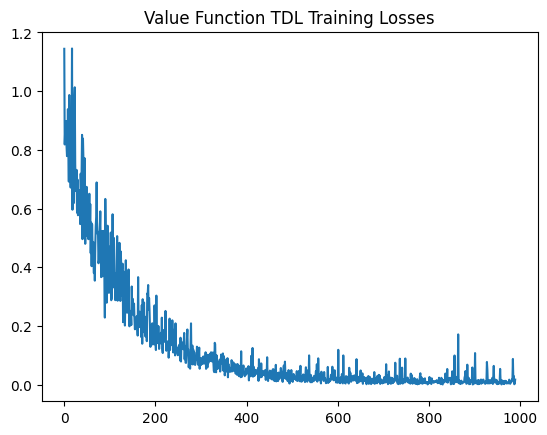

In [44]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Value Function TDL Training Losses")
plt.show()

In [45]:
vec_env.batch_reset()
config = FMCConfig(gamma=0.99, num_walkers=n, clone_strategy="cumulative_reward")
fmc = FMC(vec_env, config=config)

baseline_rewards = []

num_trials = 16
for _ in tqdm(range(num_trials), desc="Evaluating FMC Baseline"):
    vec_env.batch_reset()
    fmc.reset()
    fmc.simulate(200)
    cumulative_rewards = fmc.reward_buffer.sum(dim=1).mean().item()
    baseline_rewards.append(cumulative_rewards)

Evaluating FMC Baseline: 100%|██████████| 16/16 [01:20<00:00,  5.02s/it]


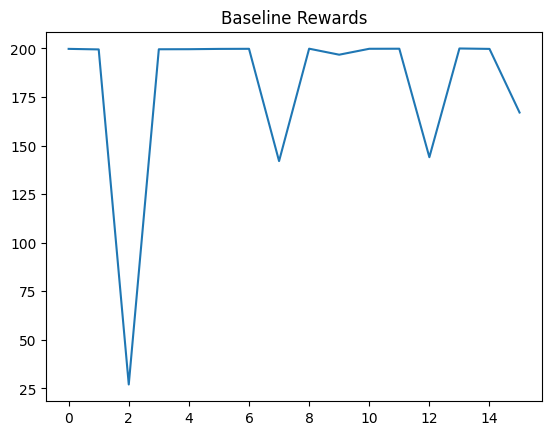

In [46]:
plt.plot(baseline_rewards)
plt.title("Baseline Rewards")
plt.show()

In [47]:
vec_env.batch_reset()
config = FMCConfig(gamma=0.99, num_walkers=n, clone_strategy="predicted_values")
fmc = FMC(vec_env, prediction_model=prediction_model, config=config)

value_exploit_rewards = []

num_trials = 16
for _ in tqdm(range(num_trials), desc="Evaluating FMC with Value Func"):
    vec_env.batch_reset()
    fmc.reset()
    fmc.simulate(200)
    cumulative_rewards = fmc.reward_buffer.sum(dim=1).mean().item()
    value_exploit_rewards.append(cumulative_rewards)

Evaluating FMC with Value Func: 100%|██████████| 16/16 [01:23<00:00,  5.21s/it]


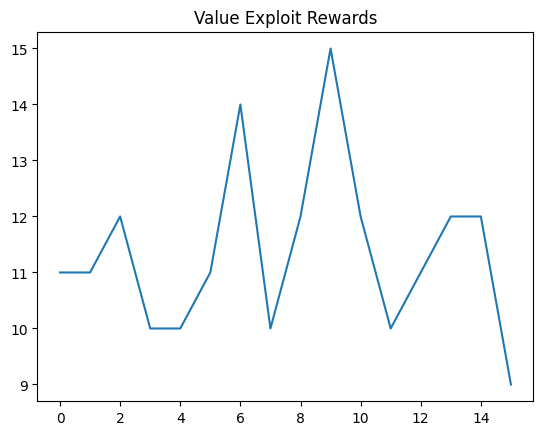

In [48]:
plt.plot(value_exploit_rewards)
plt.title("Value Exploit Rewards")
plt.show()